# Exploratory Data Analysis

In [234]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import folium
import calendar
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_dir, parse_json_files, get_file_list
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
readings = pickle.load(open("data/parsed/readings_weather_dataset_final.p", "rb"))
stations = pickle.load(open('data/parsed/stations_dataset_final.p', 'rb'))

## Station Priority

In [212]:
def map_priority_color(priority):
    if priority == 1:
        return '#ff1a1a', '#cc0000'
    elif priority == 2:
        return '#3333ff', '#0000cc'
    else: 
        return '#ffff1a', '#b3b300'
    
def create_london_map():
    min_longitude = -0.489
    min_latitude = 51.28
    max_longitude = 0.236
    max_latitude = 51.686
    london_longitude = -0.127722
    london_latitude = 51.507981
    
    return folium.Map(location=[london_latitude, london_longitude], zoom_start=12,
                      min_lat=min_latitude, max_lat=max_latitude,
                      min_lon=min_longitude, max_lon=max_longitude)
    

def draw_priority_map(stations_df):
    london_map = create_london_map()

    for index, station in stations_df.iterrows():
        colors = map_priority_color(station['Priority'])
        label = "%s - %s" % (station['Id'], station['Name'])
        
        folium.CircleMarker(location=[station['Latitude'],station['Longitude']], radius=50,
                    popup=label, color=colors[1], fill_color=colors[0]).add_to(london_map)   
        
    return london_map

priority_map = draw_priority_map(stations)

folium.Map.save(priority_map, 'reports/maps/stations_priorities.html')

## Bicycle Availability Readings

### Why are the readings not continuous?

We believe the readings are updated as follows:
* The station publishes its readings only when an change in the station occurred in the last 5 minutes
* This means most of the readings will be different than the previous one
* When this is not the case, we suspect that an equal number of bikes left and arrived to the station, leaving the station in the same state as it was before but triggering an update to be published

In [250]:
start, end = get_day_start_end(datetime(2016,5,16))
df = filter_by_time(filter_by_id(readings, 'BikePoints_14'), start, end)[['Timestamp', 'NbBikes']]
df

,Timestamp,NbBikes
305,2016-05-16 07:06:29.407,28
589,2016-05-16 07:11:30.433,36
899,2016-05-16 07:16:30.957,30
1732,2016-05-16 07:36:33.550,15
2175,2016-05-16 07:46:34.880,2
2568,2016-05-16 07:56:36.490,1
2788,2016-05-16 08:01:37.947,0
3430,2016-05-16 08:21:39.790,3
3768,2016-05-16 08:31:41.090,0
4711,2016-05-16 09:11:46.337,11


### Overview of the readings

In [201]:
def filter_by_time(df, d1, d2):
    timestamp = df['Timestamp']
    selector = (timestamp > d1) & (timestamp < d2)
    return df[selector]
    
def filter_by_id(df, idval):
    return df[df['Id'] == idval]

def plot_timeline(df, station_id, start, end):
    df = filter_by_time(filter_by_id(df, station_id), start, end)[['Timestamp']]

    df['Day'] = df['Timestamp'].apply(lambda x: x.strftime("%d/%m"))
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.replace(year=1970, month=1, day=1))
    ax = sns.stripplot(data=df, x='Timestamp', y='Day', orient='h');
    ax.set_xlim(get_day_start_end(df['Timestamp'].iloc[0]))
    ax.set_title('Readings of Station %s' % (station_id))

In [237]:
def plot_station_readings(readings, station_id, ycols1, ycols2, d1, d2):
    date_range = pd.date_range(d1, d2, freq='d')
    date_pairs = [[date_range[i], date_range[i+1]] for i in range(len(date_range)-1)]

    station_readings = filter_by_id(readings, station_id)
    slices = slice_by(station_readings, 'Timestamp', date_pairs)  
    
    # set plot properties
    ncols = 7
    nrows = int(len(slices) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)  
    fig.suptitle('Bikes Available in %s' % (station_id))
    fig.set_size_inches(18.5, 10.5)
    fig.text(0.1, 0.5, 'Number of Bikes', va='center', rotation='vertical')
        
    plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols)

def slice_by(df, col_name, date_pairs):
    groups = []
    for pair in date_pairs:
        groups.append(filter_by_time(df, pair[0], pair[1]))
    return groups

def get_day_start_end(day, hours=None):
    start = day.replace(hour=7, minute=0, second=0, microsecond=0)
    if hours is None:
        return (start, day.replace(hour=23, minute=0, second=0, microsecond=0))
    else:
        return (start, start + timedelta(hours=hours))

def plot_in_grid(axes, slices, ycols1, ycols2, nrows, ncols):
    i = 0    
    for row in range(nrows):
        for col in range(ncols):
            ax = axes[row,col]
                        
            # x axis set up            
            day_start, day_end = get_day_start_end(slices[i].iloc[0]['Timestamp'])
            xticks = pd.date_range(start=day_start,end=day_end, freq='2h')
            xlim = (day_start, day_end)

            # y axis set up
            ylim = (0, max(slices[i]['NbDocks']) + 5)
                        
            # set up data
            cols = ycols1 + ycols2
            cols.append('Timestamp')
            df = slices[i][cols]
                        
            # plot the entry                        
            sub_ax = df.plot(x='Timestamp', ax=ax, xticks=xticks,
                           legend=False, sharex=True, sharey=True,
                           xlim=xlim, ylim=ylim, secondary_y=ycols2)
                        
            sub_ax.set_xlabel(calendar.day_name[col])
            sub_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
            i+=1        

In [203]:
ycols1 = ['NbBikes', 'NbUnusableDocks']
ycols2 = []
start = datetime(2016,5,16)
end = datetime(2016,6,20)

### High Priority Stations

**Belgrove Street , King's Cross** City Center

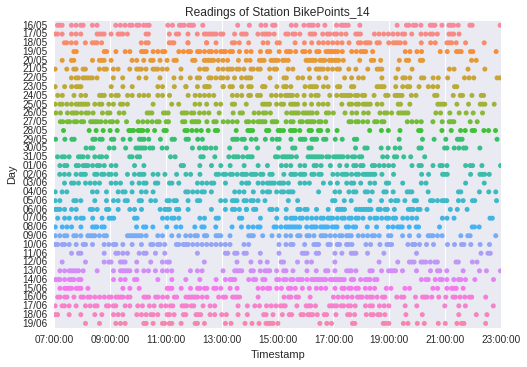

In [204]:
plot_timeline(readings, 'BikePoints_14', start, end)

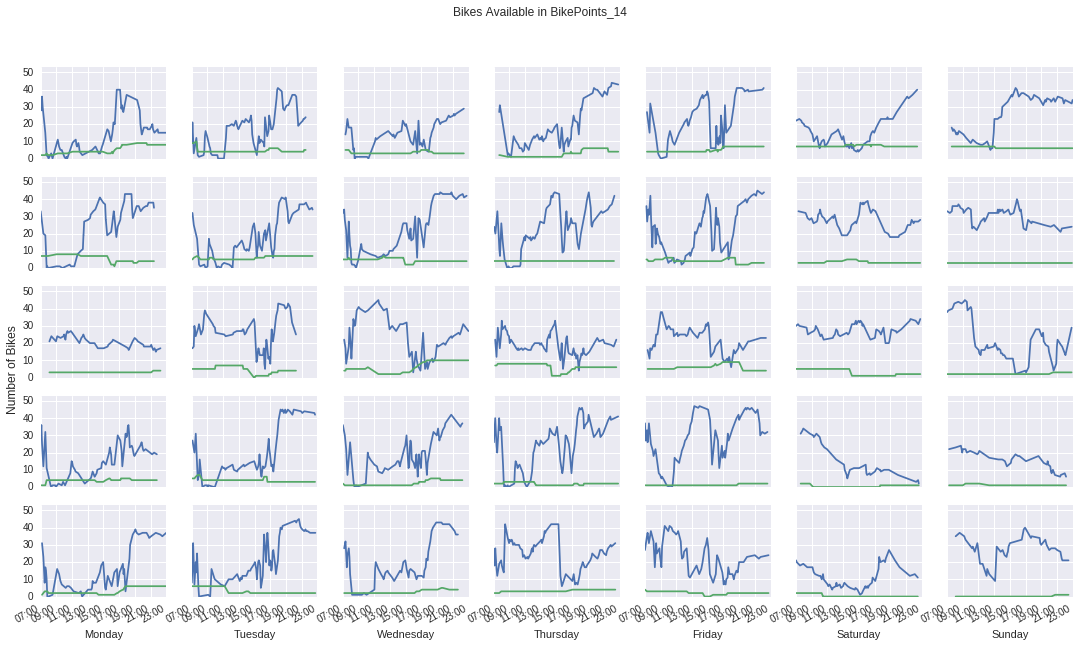

In [205]:
plot_station_readings(readings, 'BikePoints_14', ycols1, ycols2, start, end)

**Regent's Row , Haggerston ** Outside City Center

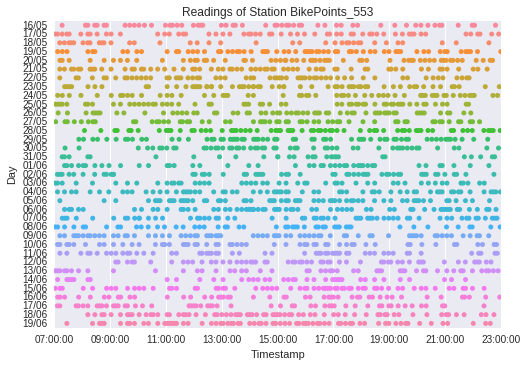

In [206]:
plot_timeline(readings, 'BikePoints_553', start, end)

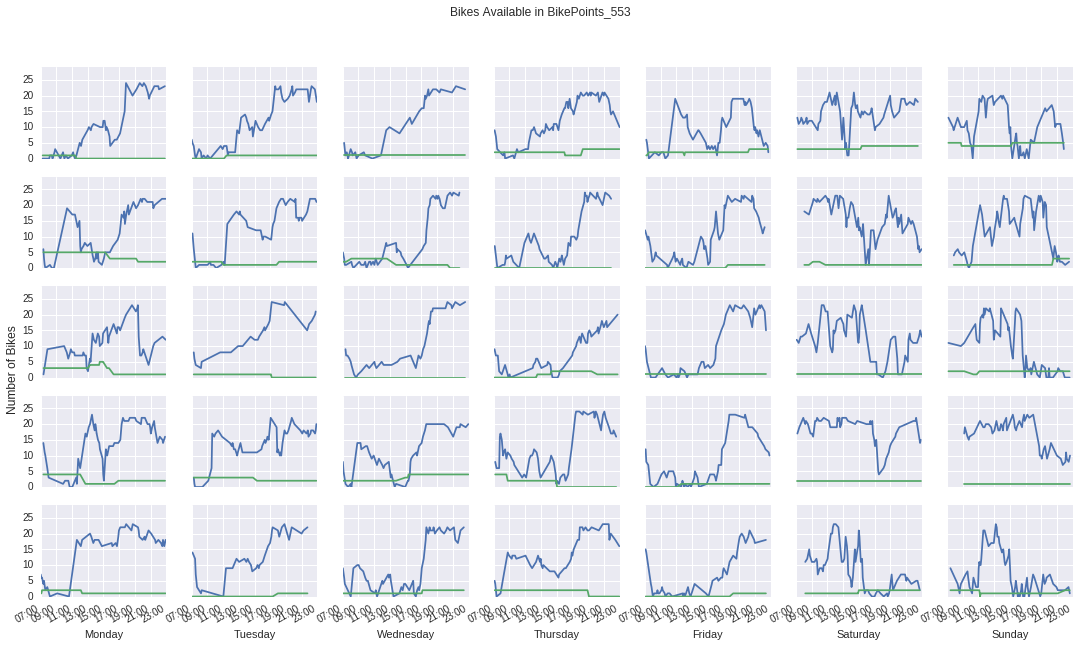

In [207]:
plot_station_readings(readings, 'BikePoints_553', ycols1, ycols2, start, end)

### Low Priority Stations
**Sackville Street, Mayfair** City Center

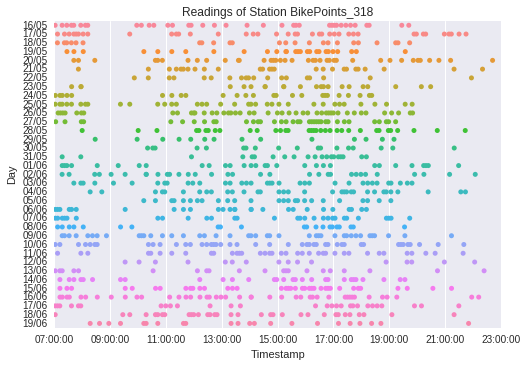

In [208]:
plot_timeline(readings, 'BikePoints_318', start, end)

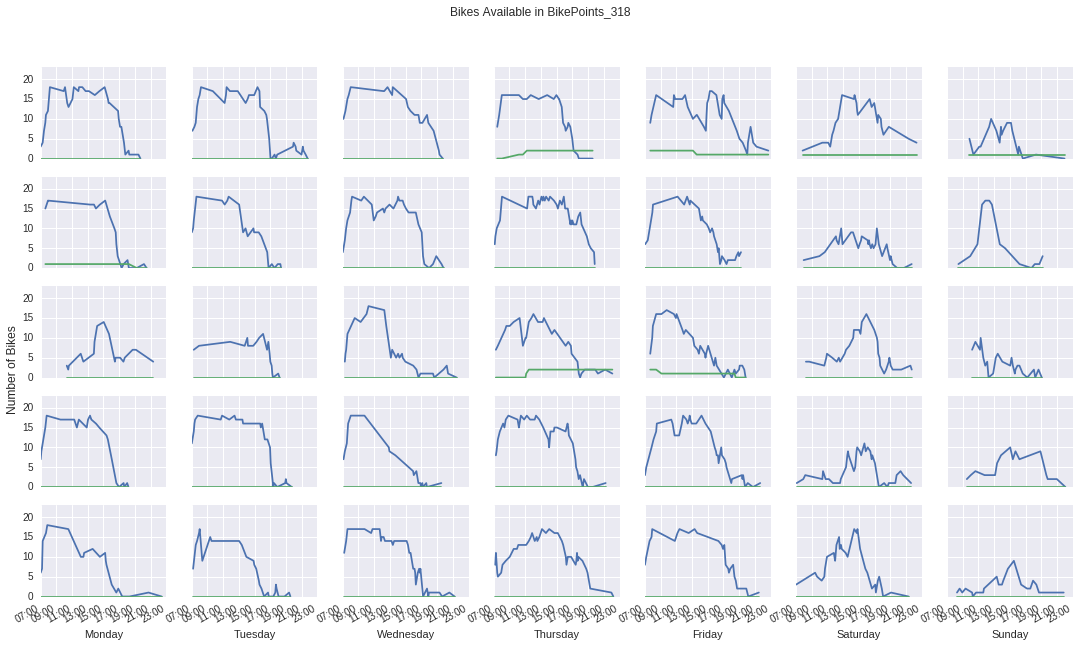

In [209]:
plot_station_readings(readings, 'BikePoints_318', ycols1, ycols2, start, end)

**St. Mark's Road, North Kensington** Outside City Center

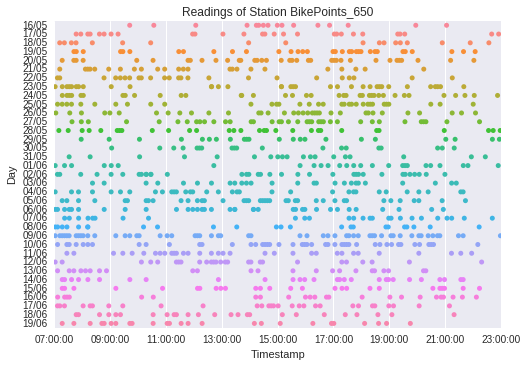

In [210]:
plot_timeline(readings, 'BikePoints_650', start, end)

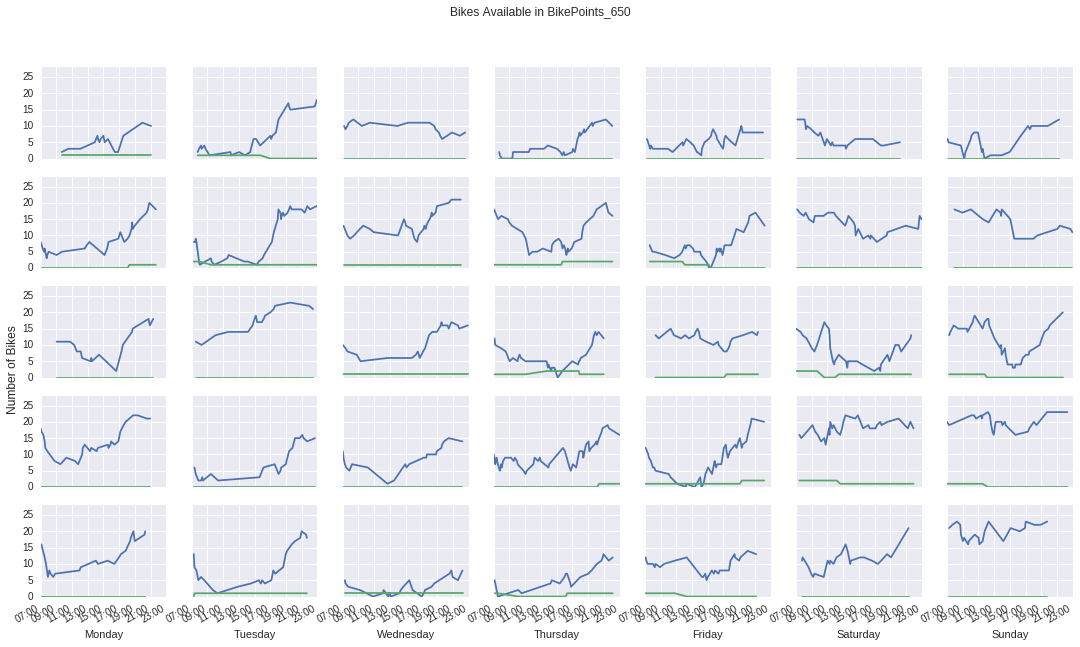

In [211]:
plot_station_readings(readings, 'BikePoints_650', ycols1, ycols2, start, end)

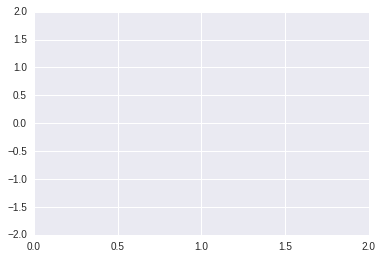

In [252]:
import matplotlib.pyplot as plt
import numpy as np

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
x = np.linspace(0, 2, 1000)

def animate(i):
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

from matplotlib import animation

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)

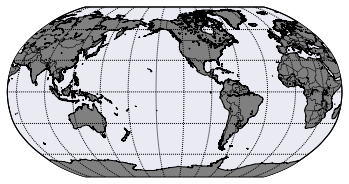